<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/09_SkimLit_nlp_milestone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (we're using data from) is here https://arxiv.org/abs/1710.06071

and here: https://arxiv.org/abs/1612.05251

## Confirm access to GPU

In [1]:
!nvidia-smi

Thu Nov  9 21:57:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

The data is available at the author's GitHub!!!: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 36.70 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the PubMed_20K dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
# dev is often just another word for validation dataset

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k dataset with numbers replaced with the @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data
https://realpython.com/read-write-files-python/

In [6]:
# Create fcn to read lines of the document
def get_lines(filename):
  """
  Reads a txt file (filename) and returns a list of the lines
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Let's read in the training lines
train_lines = get_lines(filenames[0])
train_lines[:10]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [8]:
len(train_lines)

35135

How do we want our data to look, to be best represented

List of dictionaries:

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'
   'total_lines': 11},
   another line dictionary]
```

In [9]:
test_lines = get_lines(filenames[1])
val_lines = get_lines(filenames[2])

In [10]:
# write a function to turn our lines into dictionaries
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract text data.
  """
  input_lines = get_lines(filename)
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an abstract ID
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if the line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # line is split into label and content
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower()  # get target text and lower it
        line_data["line_number"] = abstract_line_number # at what number does the line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split)-1 # how many lines there are in the total abstract
        abstract_samples.append(line_data)

    else: # the line contains the label sentence
      abstract_lines += line

  return abstract_samples

In [11]:
# Get the data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(filenames[0])
val_samples = preprocess_text_with_line_numbers(filenames[2])
test_samples = preprocess_text_with_line_numbers(filenames[1])
train_samples[:10]

CPU times: user 764 ms, sys: 90 ms, total: 855 ms
Wall time: 1.51 s


[{'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'line_number': 0,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'line_number': 1,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'line_number': 2,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ %

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df[:15]

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8
6,RESULTS,multivariable analyses revealed that patients ...,6,8
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12


In [13]:
# Distribution of labels
train_df.target.value_counts()

METHODS        9897
RESULTS        9713
CONCLUSIONS    4571
BACKGROUND     3621
OBJECTIVE      2333
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

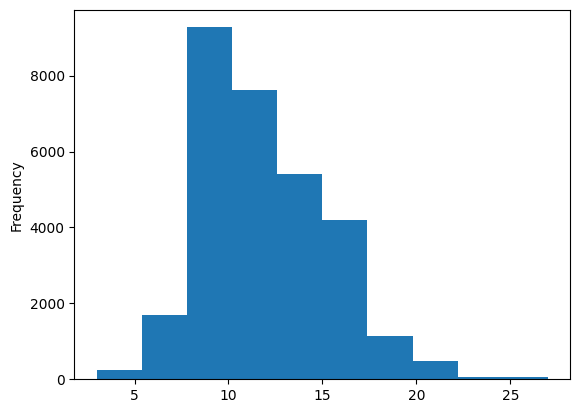

In [14]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences


In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(30135, 30212, 180040)

## Make numeric labels (ML models require numerical labels)

In [16]:
# One hot encode the labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [17]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy()) # fits the encoder and encodes at once
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([0, 4, 4, ..., 4, 4, 1])

In [18]:
# Get classnames and number of classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline - TF-IDF Multinomial Naive Bayes

https://monkeylearn.com/blog/what-is-tf-idf/

https://chrisalbon.com/Home

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipoeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate baseline model on the validation dataset
model_0.score(X=val_sentences, # equivalent to keras .evaluate()
              y=val_labels_encoded)

0.6760889712696941

In [21]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 1, 2, ..., 4, 4, 0])

### Download helper functions script

In [22]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import calculate_results

--2023-11-09 21:58:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-09 21:58:06 (86.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 67.60889712696941,
 'precision': 0.6750509747444058,
 'recall': 0.6760889712696941,
 'f1': 0.6351051244365337}

## Preparing the text - turn it into numeric format - tokenization and embedding

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [25]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.178463580554173

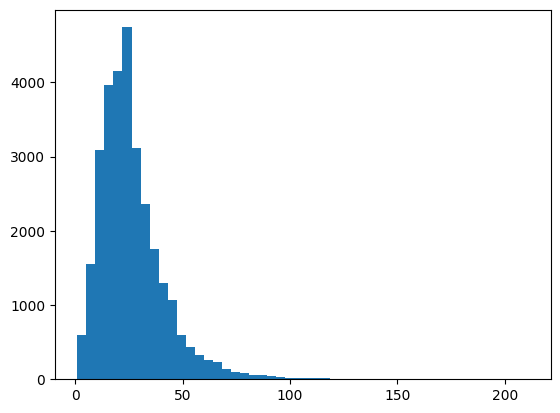

In [26]:
# What's the distribution like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=50);

Let's find out in what length 95% of the data can be contained

https://numpy.org/doc/stable/reference/generated/numpy.percentile.html

In [27]:
# How long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len
# We'll be padding and truncating sentences to that length

55

In [28]:
# Maximum sequence length in the training data (just out of curiosity)
max(sent_lens)

211

### Creating a text vectorizer layer

That layer will map our words to numbers

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [29]:
# How many words are in our vocabulary? (taken from Table 2)
max_tokens = 68000

In [30]:
# Create text tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # number of words in a sentence

In [31]:
# Adapt text tokenizer to the training data
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out text tokenizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}\n\nLength:{len(target_sentence.split())}\n\nTokenized version: {text_vectorizer(target_sentence)}")

Text:
to investigate the effects of repeated botulinum toxin a ( bont-a ) injections combined with occupational therapy , including a splint , compared with occupational therapy alone on hand function in children with unilateral spastic cerebral palsy ( uscp ) , in all international classification of functioning , disability and health ( icf ) domains .

Length:56

Tokenized version: [    6   375     2    68     4   819  4819  4540     8  5184   822   232
     7  2681    66   256     8 13128    34     7  2681    66   297    19
  1228   164     5   121     7  2183  3790   860  2499 10558     5    65
   868  2000     4  1091   589     3   110 21197  2536     0     0     0
     0     0     0     0     0     0     0]


In [33]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}\nMost common words in the vocab: {rct_20k_text_vocab[2:7]}")

Number of words in vocab: 24854
Most common words in the vocab: ['the', 'and', 'of', 'in', 'to']


In [34]:
# Get the config of the text tokenizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 24854}

### Create an embedding

In [35]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, # more captures more info, less learns faster
                               mask_zero=True, # use masking to handle variable sequence lengths - doesnt compute zero values unnecessarily
                               name="token_embedding")

In [36]:
# Show an example of embedding
print(f"Sentence before tokenization: {target_sentence}\n")
print(f"Sentence after tokenization: {text_vectorizer(target_sentence)}\n")
print(f"Sentence after embedding: {token_embed(text_vectorizer(target_sentence))}")
vectorized_sentence = text_vectorizer(target_sentence)
embedded_sentence = token_embed(vectorized_sentence)
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before tokenization: to investigate the effects of repeated botulinum toxin a ( bont-a ) injections combined with occupational therapy , including a splint , compared with occupational therapy alone on hand function in children with unilateral spastic cerebral palsy ( uscp ) , in all international classification of functioning , disability and health ( icf ) domains .

Sentence after tokenization: [    6   375     2    68     4   819  4819  4540     8  5184   822   232
     7  2681    66   256     8 13128    34     7  2681    66   297    19
  1228   164     5   121     7  2183  3790   860  2499 10558     5    65
   868  2000     4  1091   589     3   110 21197  2536     0     0     0
     0     0     0     0     0     0     0]

Sentence after embedding: [[-0.01431324  0.04529835 -0.0147723  ... -0.0200604  -0.04758792
   0.04623559]
 [-0.02613181  0.02835727 -0.031233   ... -0.04590119 -0.03456827
  -0.02431065]
 [-0.03048285  0.00882723  0.01952997 ... -0.0073599   0.00284725

## Turning data into prefetch datasets to increase speed of loading

https://www.tensorflow.org/guide/data_performance?hl=pl

https://www.tensorflow.org/api_docs/python/tf/data

In [37]:
# Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Take the tensor slice datasets and turn them into prefetch datasets and into batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D

In [39]:
# Build the model the functional way
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_tokens = text_vectorizer(inputs)
token_embeddings = token_embed(text_tokens)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(optimizer="Adam",
                loss="categorical_crossentropy",
                metrics="accuracy")

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           3181312   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [45]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs=5,
                              # steps_per_epoch=int(0.1*len(train_dataset)) # no need for this as the model trains fast anyway
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/5
942/942 [==============================] - 11s 12ms/step - loss: 0.6550 - accuracy: 0.7533 - val_loss: 0.6364 - val_accuracy: 0.7563
Epoch 2/5
942/942 [==============================] - 5s 6ms/step - loss: 0.4533 - accuracy: 0.8429 - val_loss: 0.6508 - val_accuracy: 0.7653
Epoch 3/5
942/942 [==============================] - 10s 10ms/step - loss: 0.3144 - accuracy: 0.8963 - val_loss: 0.7545 - val_accuracy: 0.7490
Epoch 4/5
942/942 [==============================] - 9s 10ms/step - loss: 0.2091 - accuracy: 0.9363 - val_loss: 0.9114 - val_accuracy: 0.7354
Epoch 5/5
942/942 [==============================] - 8s 9ms/step - loss: 0.1415 - accuracy: 0.9589 - val_loss: 1.1091 - val_accuracy: 0.7211


In [46]:
# Evaluate on the whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 1.0874 - accuracy: 0.7291


[1.0873762369155884, 0.7291142344474792]

In [47]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[9.8295850e-01, 3.4001169e-03, 3.1525330e-04, 1.3311121e-02,
        1.4991878e-05],
       [7.5636387e-01, 1.9760817e-01, 3.7563057e-04, 4.5610927e-02,
        4.1377625e-05],
       [2.5245470e-01, 1.1105035e-03, 8.2313818e-05, 7.4635249e-01,
        3.5410572e-10],
       ...,
       [5.7812735e-12, 2.9525285e-07, 6.0068663e-07, 7.7536783e-11,
        9.9999905e-01],
       [8.2709128e-03, 8.5020077e-01, 7.6929276e-04, 1.1802337e-04,
        1.4064099e-01],
       [8.3980989e-03, 9.9084431e-01, 7.4101437e-04, 1.0261351e-05,
        6.3325765e-06]], dtype=float32)

In [48]:
# Convert to classes
model_1_preds = tf.argmax(tf.squeeze(model_1_pred_probs), axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [49]:
# Calculate model 1 results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 72.91142592347411,
 'precision': 0.7291193194731586,
 'recall': 0.7291142592347412,
 'f1': 0.7268269232050371}

In [51]:
baseline_results

{'accuracy': 67.60889712696941,
 'precision': 0.6750509747444058,
 'recall': 0.6760889712696941,
 'f1': 0.6351051244365337}